<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_06_5_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T81-558: Applications of Deep Neural Networks
**Module 6: Convolutional Neural Networks (CNN) for Computer Vision**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 6 Material

* Part 6.1: Image Processing in Python [[Video]](https://www.youtube.com/watch?v=V-IUrfTJMm4&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_06_1_python_images.ipynb)
* Part 6.2: Using Convolutional Neural Networks [[Video]](https://www.youtube.com/watch?v=nU_T2PPigUQ&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_06_2_cnn.ipynb)
* Part 6.3: Using Pretrained Neural Networks with Keras [[Video]](https://www.youtube.com/watch?v=TXqI9fp0imI&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_06_3_resnet.ipynb)
* Part 6.4: Looking at Keras Generators and Image Augmentation [[Video]](https://www.youtube.com/watch?v=epfpxiXRL3U&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_06_4_keras_images.ipynb)
* **Part 6.5: Recognizing Multiple Images with YOLOv5** [[Video]](https://www.youtube.com/watch?v=zwEmzElquHw&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_06_5_yolo.ipynb)

# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.
  Running the following code will map your GDrive to ```/content/drive```.

In [1]:
try:
    from google.colab import drive
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: using Google CoLab
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Part 6.5: Recognizing Multiple Images with YOLO5

Programmers typically design convolutional neural networks to classify a single item centered in an image. However, as humans, we can recognize many items in our field of view in real-time. It is advantageous to recognize multiple items in a single image. One of the most advanced means of doing this is YOLOv5. You Only Look Once (YOLO) was introduced by Joseph Redmon, who supported YOLO up through V3. [[Cite:redmon2016you]](https://arxiv.org/abs/1506.02640) The fact that YOLO must only look once speaks to the efficiency of the algorithm. In this context, to "look" means to perform one scan over the image. It is also possible to run YOLO on live video streams.

 
Joseph Redmon left computer vision to pursue other interests. The current version, YOLOv5 is supported by the startup company [Ultralytics](https://ultralytics.com/), who released the open-source library that we use in this class.[[Cite:zhu2021tph]](https://arxiv.org/abs/2108.11539)

Researchers have trained YOLO on a variety of different computer image datasets. The version of YOLO weights used in this course is from the dataset Common Objects in Context (COCO). [[Cite: lin2014microsoft]](https://arxiv.org/abs/1405.0312) This dataset contains images labeled into 80 different classes. COCO is the source of the file coco.txt used in this module.

## Using YOLO in Python

To use YOLO in Python, we will use the open-source library provided by Ultralytics.

* [YOLOv5 GitHub](https://github.com/ultralytics/yolov5)

The code provided in this notebook works equally well when run either locally or from Google CoLab. It is easier to run YOLOv5 from CoLab, which is recommended for this course.

We begin by obtaining an image to classify.


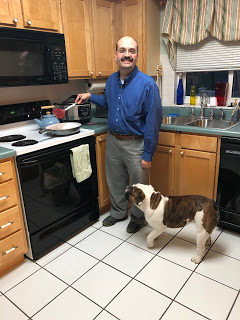

In [2]:
import urllib.request
import shutil
from IPython.display import Image
!mkdir /content/images/

URL = "https://github.com/jeffheaton/t81_558_deep_learning"
URL += "/raw/master/photos/jeff_cook.jpg"
LOCAL_IMG_FILE = "/content/images/jeff_cook.jpg"

with urllib.request.urlopen(URL) as response, \
  open(LOCAL_IMG_FILE, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

Image(filename=LOCAL_IMG_FILE)

## Installing YOLOv5

YOLO is not available directly through either PIP or CONDA. Additionally, YOLO is not installed in Google CoLab by default. Therefore, whether you wish to use YOLO through CoLab or run it locally, you need to go through several steps to install it. This section describes the process of installing YOLO. The same steps apply to either CoLab or a local install. For CoLab, you must repeat these steps each time the system restarts your virtual environment. You must perform these steps only once for your virtual Python environment for a local install. If you are installing locally, install to the same virtual environment you created for this course. The following commands install YOLO directly from its GitHub repository.

In [3]:
import sys

!git clone https://github.com/ultralytics/yolov5 --tag 6.2  # clone
!mv /content/6.2 /content/yolov5
%pip install -qr /content/yolov5/requirements.txt  # install
sys.path.insert(0,'/content/yolov5')

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.2-195-gdf80e7c Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.8/166.8 GB disk)


Next, we will run YOLO from the command line and classify the previously downloaded kitchen picture.  You can run this classification on any image you choose.

rm: cannot remove '/content/yolov5/runs/detect/*': No such file or directory
mkdir: cannot create directory ‘/content/images’: File exists
cp: cannot stat '/content/street/jeff_cook.jpg': No such file or directory
detect: weights=['yolov5s.pt'], source=/content/images/, data=yolov5/data/coco128.yaml, imgsz=[1024, 1024], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-195-gdf80e7c Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

100% 14.1M/14.1M [00:00<00:00, 236MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/1 /content/images/jeff_cook.jpg: 1024x768 1 person, 1 dog, 2 bottles, 1 microwave, 1 oven, 2 sinks, 2

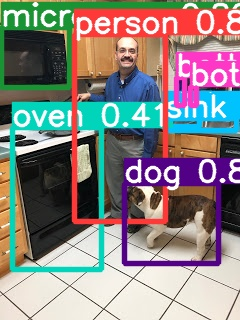

In [4]:
# Prepare directories for YOLO command line
!rm -R /content/yolov5/runs/detect/*
!mkdir /content/images
!cp /content/street/jeff_cook.jpg /content/images

# Run YOLO to classify
!python /content/yolov5/detect.py --weights yolov5s.pt --img 1024 \
  --conf 0.25 --source /content/images/

# Display the images
from IPython.display import Image

URL = '/content/yolov5/runs/detect/exp/jeff_cook.jpg'
Image(filename=URL, width=300)

In [5]:
!ls /content/yolov5/

benchmarks.py	 detect.py   models	       runs	  tutorial.ipynb
classify	 export.py   __pycache__       segment	  utils
CONTRIBUTING.md  hubconf.py  README.md	       setup.cfg  val.py
data		 LICENSE     requirements.txt  train.py


## Running YOLOv5

In addition to the command line execution, we just saw.  The following code adds the downloaded YOLOv5 to Python's environment, allowing **yolov5** to be imported like a regular Python library.

In [6]:
import torch

# Model
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5n - yolov5x6, custom

# Inference
results = yolo_model(LOCAL_IMG_FILE)

# Results
df = results.pandas().xyxy[0]
df

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 v6.2-195-gdf80e7c Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gra

,xmin,ymin,xmax,ymax,confidence,class,name
0,125.092232,182.010025,219.074036,264.044983,0.928736,16,dog
1,72.338425,36.174423,162.752075,229.957077,0.928245,0,person
2,0.428009,25.537472,68.613434,89.955139,0.891785,68,microwave
3,0.000000,98.033714,103.113159,266.426483,0.739207,69,oven
4,176.110916,76.847527,183.783249,105.030785,0.725925,39,bottle
5,189.972397,85.284508,196.409378,105.729591,0.593492,39,bottle
6,161.864563,115.693741,237.386475,131.211624,0.571422,71,sink
7,216.053223,137.275635,239.968109,230.737457,0.364453,69,oven
8,181.397934,82.266541,195.568832,105.023056,0.252385,39,bottle


It is important to note that the **yolo** class instantiated here is a callable object, which can fill the role of both an object and a function. Acting as a function, *yolo* returns a Pandas dataframe that contains the bounding boxes (xmin/xmax and ymin/ymax), confidence, and name/class of each item detected. 

Your program should use these values to perform whatever actions you wish due to the input image.  The following code displays the images detected above the threshold.

You can obtain the counts of images through the use of a Pandas groupby and pivot.

In [7]:
df2 = df[['name','class']].groupby(by=["name"]).count().reset_index()
df2.columns = ['name','count']
df2['image'] = 1
df2.pivot(index=['image'],columns='name',values='count').reset_index().fillna(0)

name,image,bottle,dog,microwave,oven,person,sink
0,1,3,1,1,2,1,1


# Module 6 Assignment

You can find the first assignment here: [assignment 6](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/assignments/assignment_yourname_class6.ipynb)